# 분석 목적
- 기존 데이터 셋의 country_destination 컬럼값은 10개의 국가명과 NDF, other로 구성되어 있음
- country_destination 컬럼값을 0(예약하지 않음), 1(예약함)로 변경하여 로지스틱 회귀로 예약 여부 예측
- 회귀 모델 결과 분석을 통해 예약에 중요한 특성을 도출하고자 함

# 결론
- 중요한 특성: 목적지의 면적, 위도, 사용자의 여행 거리 등의 특성이 예약 전환율에 큰 영향을 미치는 것으로 보임
- 영향이 적은 특성: 특정 브라우저나 성별 등의 특성은 전환율에 거의 영향을 미치지 않음
- 전략적 인사이트: 마케팅 및 서비스 전략을 세울 때, 전환율에 큰 영향을 미치는 주요 특성에 집중하는 것이 효과적일 수 있음. 예를 들어, 인기 있는 목적지나 장거리 여행객을 대상으로 한 맞춤형 마케팅 캠페인을 고려할 수 있음

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
train = pd.read_csv('train_clean_with_two_datasets.csv')

In [4]:
train.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,unique_action_types,unique_action_details,unique_device_types,total_secs_elapsed,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,d1mm9tcy42,2014-01-01,20140101000936,male,62.0,basic,0,en,sem-non-brand,google,...,6,9,2,3427529.0,0.0,0.0,0.0,0.0,eng,0.0
1,yo8nz8bqcq,2014-01-01,20140101001558,female,37.0,basic,0,en,direct,direct,...,5,9,1,207842.0,0.0,0.0,0.0,0.0,eng,0.0
2,4grx6yxeby,2014-01-01,20140101001639,other,44.0,basic,0,en,sem-brand,google,...,6,8,2,1135444.0,0.0,0.0,0.0,0.0,eng,0.0


In [5]:
train.isnull().sum().any()

False

In [6]:
# 예약 전환 여부를 나타내는 타겟 변수 생성 (country_destination이 'NDF'가 아닌 경우 전환으로 간주)
train['is_conversion'] = train['country_destination'].apply(lambda x: 0 if x == 'NDF' else 1)

# 필요 없는 열 제거
train.drop(['id', 'date_account_created', 'timestamp_first_active', 'country_destination'], axis=1, inplace=True)

In [7]:
# 특성(X)과 타겟 변수(y) 설정
X = train.drop('is_conversion', axis=1)
y = train['is_conversion']

In [8]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

# 전처리: 범주형 변수는 원-핫 인코딩, 수치형 변수는 표준화
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [9]:
# 로지스틱 회귀 모델 파이프라인 생성
model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

# 훈련 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.95
Precision: 1.00
Recall: 0.88
F1 Score: 0.93


In [10]:
# 회귀계수 추출
logistic_model = model.named_steps['logisticregression']
feature_names = model.named_steps['columntransformer'].get_feature_names_out()
coefficients = logistic_model.coef_[0]

# 특성 이름과 회귀계수 매핑
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 절대값 기준으로 회귀계수 정렬
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

# 중요한 특성 확인
print(feature_importance)

                                 Feature  Coefficient  Absolute_Coefficient
10                  num__destination_km2     2.344376              2.344376
7                   num__lat_destination     1.948360              1.948360
9                       num__distance_km     1.689387              1.689387
8                   num__lng_destination    -1.552827              1.552827
87       cat__first_browser_AOL Explorer    -0.917518              0.917518
..                                   ...          ...                   ...
12                    cat__gender_female    -0.000703              0.000703
108        cat__first_browser_Opera Mini     0.000097              0.000097
116        cat__first_browser_TenFourFox     0.000038              0.000038
117  cat__first_browser_TheWorld Browser     0.000034              0.000034
111          cat__first_browser_RockMelt     0.000003              0.000003

[142 rows x 3 columns]


#### 회귀계수 의미
- 양의 회귀계수: 해당 특성이 증가할수록 전환될 확률이 높아짐
- 음의 회귀계수: 해당 특성이 증가할수록 전환될 확률이 낮아짐

#### 절대 회귀계수
- 해당 특성이 전환율에 얼마나 큰 영향을 미치는지 나타내는 것으로 값이 클수록 영향력이 큼

#### 1. num__destination_km2 (회귀계수: 2.344376):
- 해석: 목적지의 면적이 클수록 사용자가 예약할 확률이 높아지며, 이는 대도시나 인기 관광지가 포함된 넓은 지역이 더 많은 예약을 유도할 가능성이 있음을 시사함

#### 2. num__lat_destination (회귀계수: 1.948360):
 - 해석: 목적지의 위도가 높을수록 예약할 확률이 높아지며, 이는 특정 위도 범위에 위치한 목적지가 더 매력적일 수 있음을 나타냄

#### 3. num__distance_km (회귀계수: 1.689387):
 - 해석: 사용자의 출발지와 목적지 간의 거리가 멀수록 예약할 확률이 높아지며, 장거리 여행이 더 계획적이고 예약 필요성이 높기 때문으로 생각됨

#### 4. num__lng_destination (회귀계수: -1.552827):
 - 해석: 목적지의 경도가 낮을수록 예약할 확률이 낮아지며, 이는 특정 경도 범위에 위치한 목적지가 덜 매력적일 수 있음을 나타냄

#### 5. cat__first_browser_AOL Explorer (회귀계수: -0.917518):
 - 해석: 첫 번째 브라우저가 AOL Explorer인 경우, 예약할 확률이 낮아지며, 이는 특정 브라우저 사용자가 덜 활동적이거나 예약 행동 패턴이 다를 수 있음을 나타냄

#### 6. cat__gender_female (회귀계수: -0.000703):
 - 해석: 사용자가 여성인 경우 예약할 확률에 거의 영향을 미치지 않으며, 이는 성별이 전환율에 큰 영향을 미치지 않는다는 것을 의미할 수 있음

#### 7. cat__first_browser_RockMelt (회귀계수: 0.000003):
 - 해석: 첫 번째 브라우저가 RockMelt인 경우, 예약할 확률에 거의 영향을 미치지 않으며, 이는 해당 브라우저 사용자가 매우 적거나 예약 행동에 거의 영향을 미치지 않음을 나타낼 수 있음

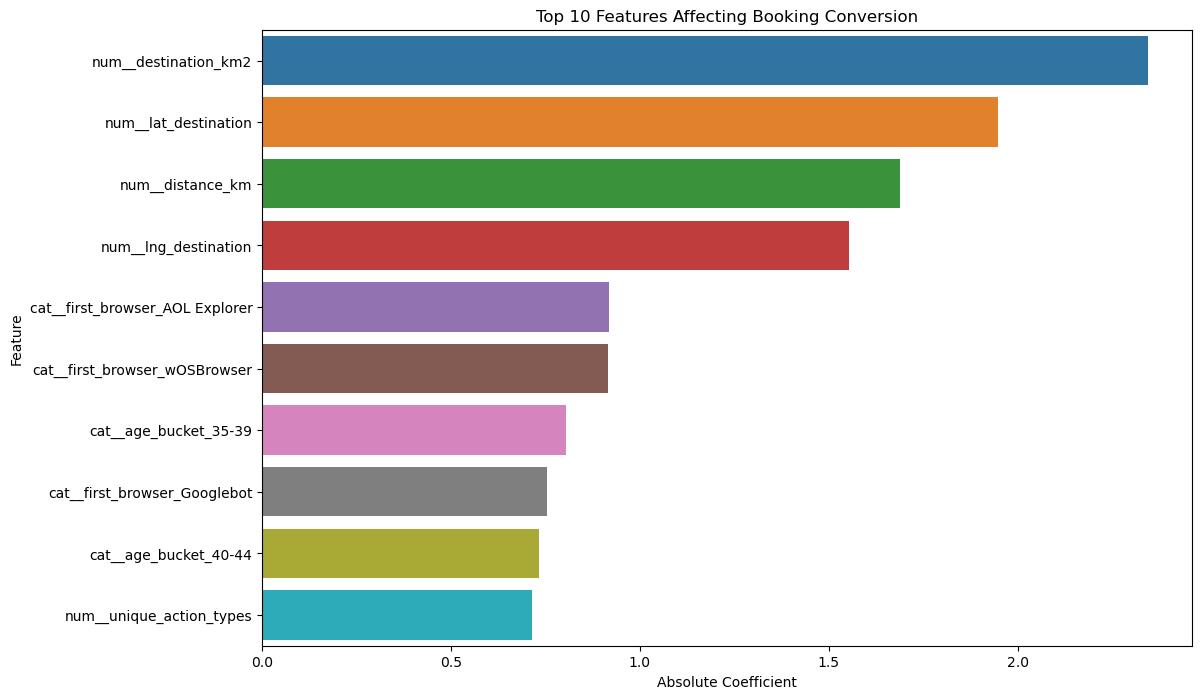

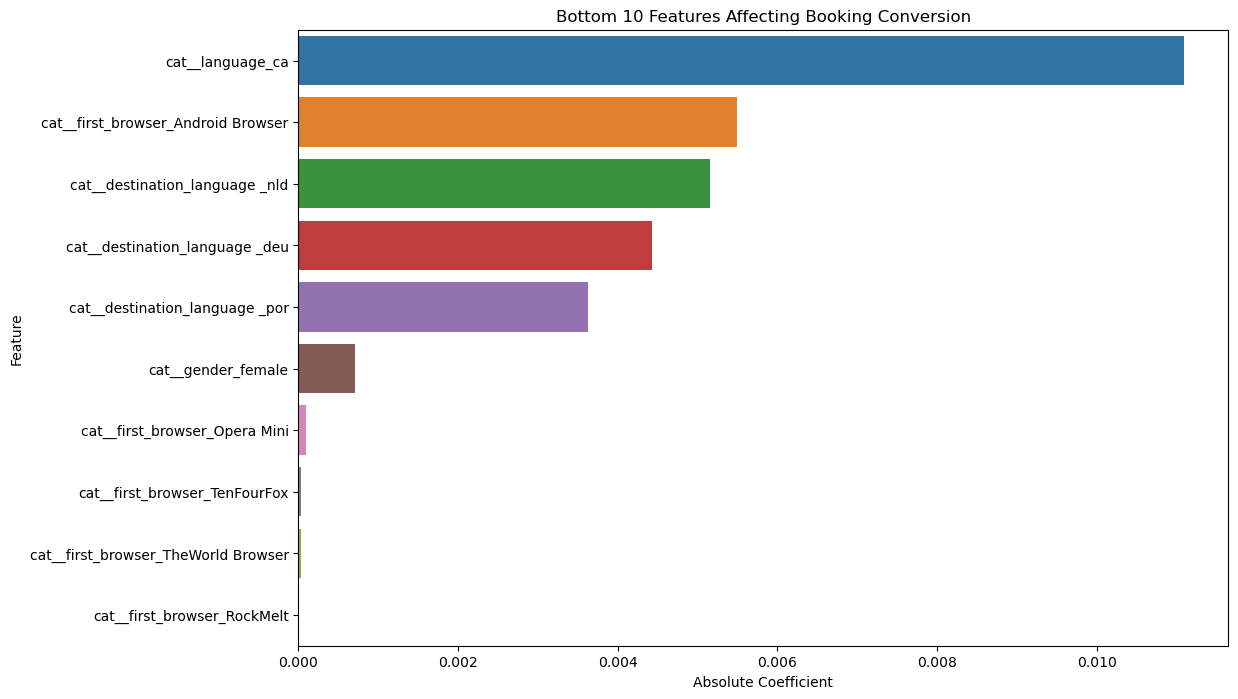

In [11]:
# 상위 10개의 특성 선택
top_features = feature_importance.head(10)

# 하위 10개의 특성 선택
bottom_features = feature_importance.tail(10)

# 상위 10개 중요한 특성 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, x='Absolute_Coefficient', y='Feature')
plt.title('Top 10 Features Affecting Booking Conversion')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.show()

# 하위 10개 중요한 특성 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=bottom_features, x='Absolute_Coefficient', y='Feature')
plt.title('Bottom 10 Features Affecting Booking Conversion')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.show()

### 결론
- 중요한 특성: 목적지의 면적, 위도, 사용자의 여행 거리 등의 특성이 예약 전환율에 큰 영향을 미치는 것으로 보임
- 영향이 적은 특성: 특정 브라우저나 성별 등의 특성은 전환율에 거의 영향을 미치지 않음
- 전략적 인사이트: 마케팅 및 서비스 전략을 세울 때, 전환율에 큰 영향을 미치는 주요 특성에 집중하는 것이 효과적일 수 있음. 예를 들어, 인기 있는 목적지나 장거리 여행객을 대상으로 한 맞춤형 마케팅 캠페인을 고려할 수 있음